In [1]:
import os
import pandas
import functools
import numpy as np
import tensorflow as tf
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
data_dir = "GTSDB/"
np_images_filename = "images.npy"
input_shape = (320, 544, 3)
grid_shape = (10, 17, 2) # not easiely modifiebl
base_model = tf.keras.applications.vgg19

/home/matech/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
model = base_model.VGG19(input_shape=(320, 544, 3), include_top=False)
print(type(model))

<class 'tensorflow.python.keras._impl.keras.engine.training.Model'>


In [3]:
print(type(model.layers))

<class 'list'>


In [15]:
for layer in model.layers:
    layer.trainable = True
    print(type(layer), layer.output_shape)

<class 'tensorflow.python.keras._impl.keras.engine.topology.InputLayer'> (None, 320, 544, 3)
<class 'tensorflow.python.keras._impl.keras.layers.convolutional.Conv2D'> (None, 320, 544, 64)
<class 'tensorflow.python.keras._impl.keras.layers.convolutional.Conv2D'> (None, 320, 544, 64)
<class 'tensorflow.python.keras._impl.keras.layers.pooling.MaxPooling2D'> (None, 160, 272, 64)
<class 'tensorflow.python.keras._impl.keras.layers.convolutional.Conv2D'> (None, 160, 272, 128)
<class 'tensorflow.python.keras._impl.keras.layers.convolutional.Conv2D'> (None, 160, 272, 128)
<class 'tensorflow.python.keras._impl.keras.layers.pooling.MaxPooling2D'> (None, 80, 136, 128)
<class 'tensorflow.python.keras._impl.keras.layers.convolutional.Conv2D'> (None, 80, 136, 256)
<class 'tensorflow.python.keras._impl.keras.layers.convolutional.Conv2D'> (None, 80, 136, 256)
<class 'tensorflow.python.keras._impl.keras.layers.convolutional.Conv2D'> (None, 80, 136, 256)
<class 'tensorflow.python.keras._impl.keras.layers

In [5]:
def get_image(img_name):
    img = imread(img_name)
    img = imresize(img, input_shape)
    img = img.astype(float)
    return img
    
if os.path.isfile(np_images_filename):
    print("Loading: " + np_images_filename)
    images = np.load(np_images_filename)
else:
    images = np.array([get_image(data_dir + "00000.ppm")])
    for i in range(1, 900):
        img_name = data_dir + str(i).zfill(5) + ".ppm"
        print("Processing: " + img_name)
        img = get_image(img_name)
        images = np.concatenate((images, [img]), axis=0)
        images = base_model.preprocess_input(images)
        print(images.shape)
        np.save(np_images_filename, images)
print(images.dtype)

Loading: images.npy
float64


In [6]:
def grid_of_center(box): #("x_min", "y_min", "x_max", "y_max")
    original_with = 1360
    original_height = 800
    c_x = (box[0] + box[2])/2
    c_y = (box[1] + box[3])/2
    return int(c_y/original_height*grid_shape[0]), int(c_x/original_with*grid_shape[1])


labels = pandas.read_csv(os.path.join(data_dir, "gt.txt"), sep=";", header=None, 
                         names=("file_name", "x_min", "y_min", "x_max", "y_max", "label"))
labels_nn = np.zeros((images.shape[0], grid_shape[0], grid_shape[1], grid_shape[2]))
labels_nn[:,:,:,0] = 1
for i in range(images.shape[0]):
    l = labels_nn[i, :, :, :]
    img_name = str(i).zfill(5) + ".ppm"
    #print("Processing: " + img_name)
    for row in labels[labels["file_name"] == img_name].iterrows():
        row = list(row[1])
        u, v = grid_of_center(row[1:-1])
        l[u, v, 0] = 0
        l[u, v, 1] = 1

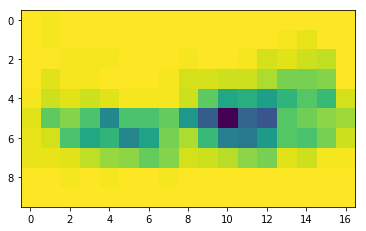

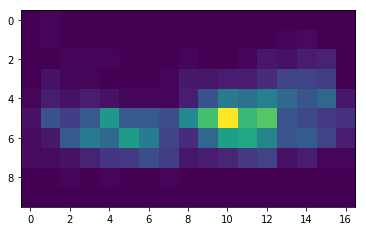

In [7]:
plt.imshow(labels_nn[:,:,:,0].mean(0).reshape((10,17)))
plt.show()
plt.imshow(labels_nn[:,:,:,1].mean(0).reshape((10,17)))
plt.show()

In [16]:
l = model.output
# l = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding="same")(l)
# l = tf.keras.layers.Flatten()(l)
# l = tf.keras.layers.Dense(10*17*128)(l)
# l = tf.keras.layers.Reshape((10, 17, 128))(l)
# l = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same")(l)
l = tf.keras.layers.Flatten()(l)
l = tf.keras.layers.Dense(functools.reduce(lambda x, y: x*y, grid_shape))(l)
l = tf.keras.layers.Reshape((grid_shape[0]*grid_shape[1], grid_shape[2]))(l)
l = tf.keras.layers.Activation("softmax")(l)
# l = tf.keras.layers.Dropout(0.5)(l)
predictions = tf.keras.layers.Reshape(grid_shape)(l)

# creating the final model 
model_final = tf.keras.models.Model(inputs=model.input, outputs=predictions)

# compile the model 
def categorical_crossentropy(y_true, y_pred):
    K = tf.keras.backend
    y_true = K.reshape(y_true, (10*17, 2))
    y_pred = K.reshape(y_pred, (10*17, 2))
    return K.categorical_crossentropy(y_true, y_pred)
model_final.compile(loss="mean_absolute_error", optimizer="adam", metrics=["accuracy"])

for layer in model_final.layers:
    print(type(layer), layer.output_shape)

<class 'tensorflow.python.keras._impl.keras.engine.topology.InputLayer'> (None, 320, 544, 3)
<class 'tensorflow.python.keras._impl.keras.layers.convolutional.Conv2D'> (None, 320, 544, 64)
<class 'tensorflow.python.keras._impl.keras.layers.convolutional.Conv2D'> (None, 320, 544, 64)
<class 'tensorflow.python.keras._impl.keras.layers.pooling.MaxPooling2D'> (None, 160, 272, 64)
<class 'tensorflow.python.keras._impl.keras.layers.convolutional.Conv2D'> (None, 160, 272, 128)
<class 'tensorflow.python.keras._impl.keras.layers.convolutional.Conv2D'> (None, 160, 272, 128)
<class 'tensorflow.python.keras._impl.keras.layers.pooling.MaxPooling2D'> (None, 80, 136, 128)
<class 'tensorflow.python.keras._impl.keras.layers.convolutional.Conv2D'> (None, 80, 136, 256)
<class 'tensorflow.python.keras._impl.keras.layers.convolutional.Conv2D'> (None, 80, 136, 256)
<class 'tensorflow.python.keras._impl.keras.layers.convolutional.Conv2D'> (None, 80, 136, 256)
<class 'tensorflow.python.keras._impl.keras.layers

In [20]:
n_img = 100
batch_size = 1
res = model_final.predict(images[:n_img, :, :, :], min(batch_size, n_img))

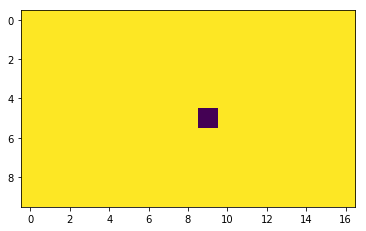

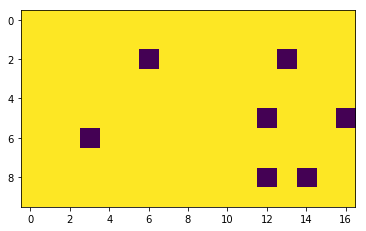

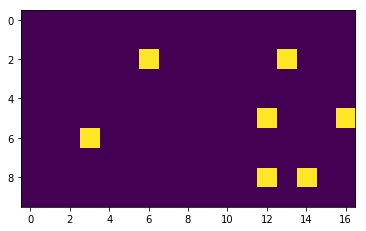

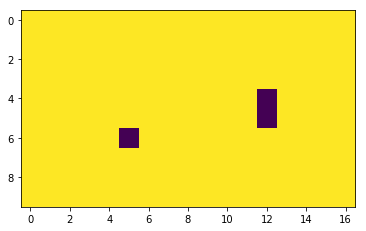

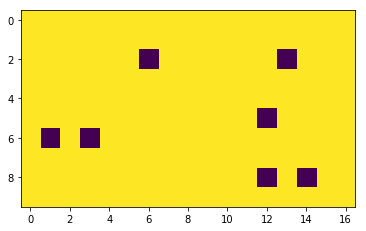

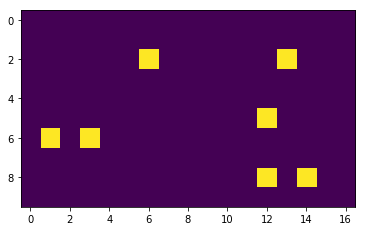

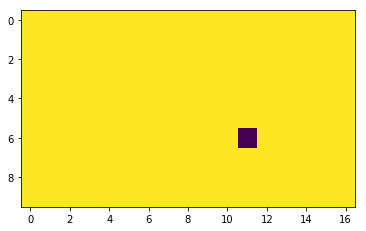

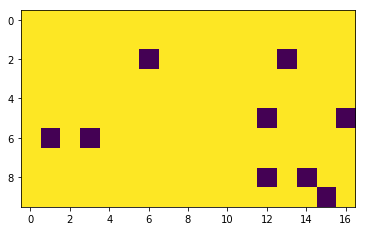

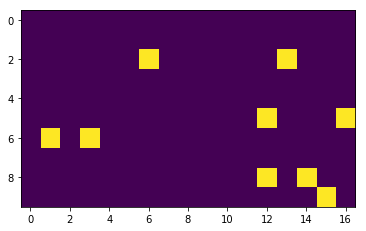

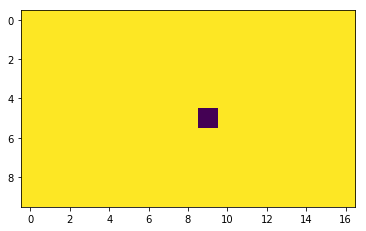

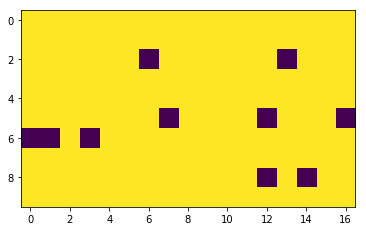

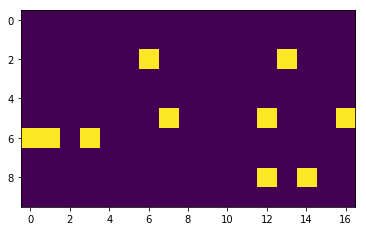

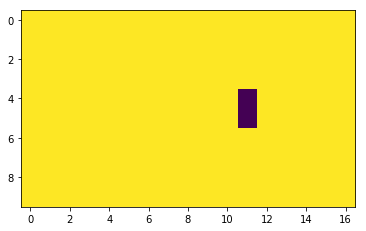

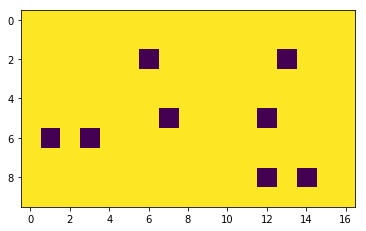

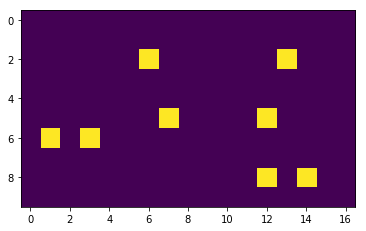

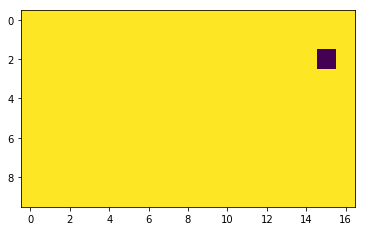

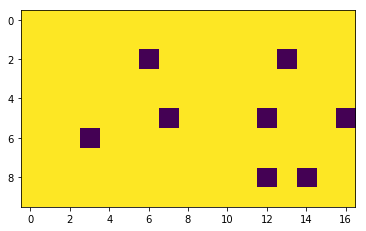

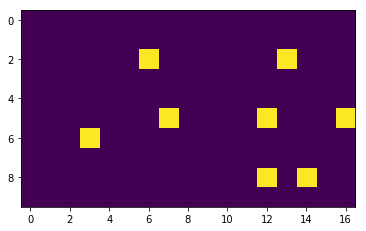

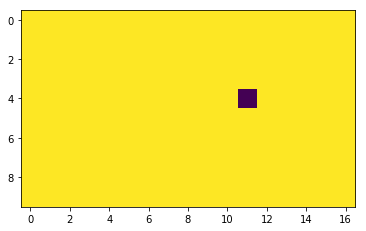

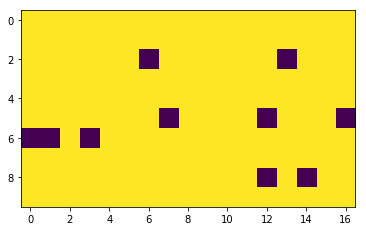

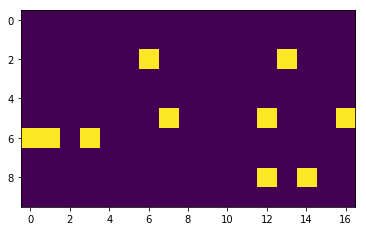

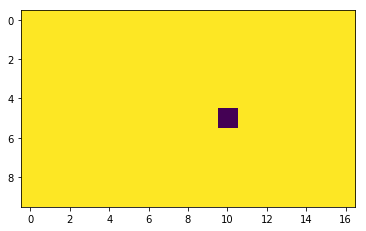

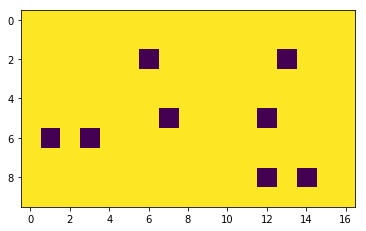

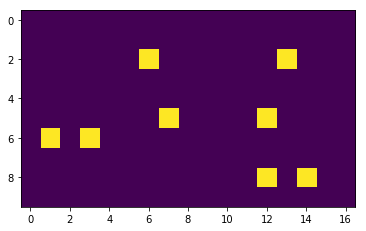

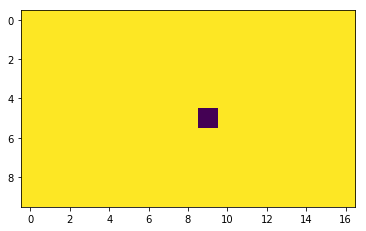

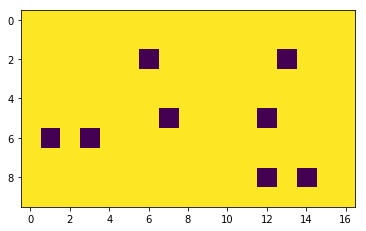

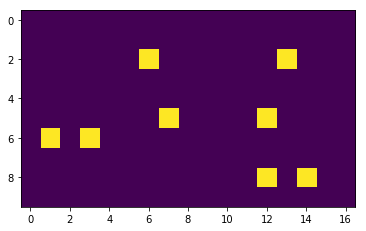

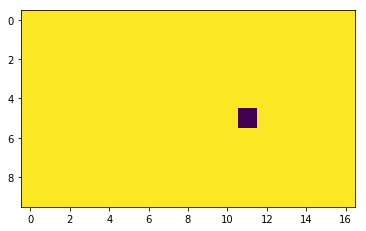

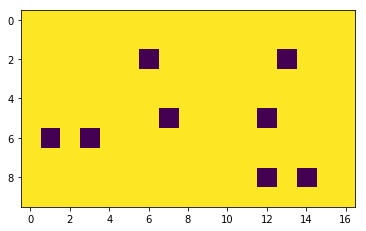

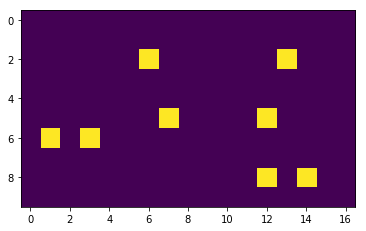

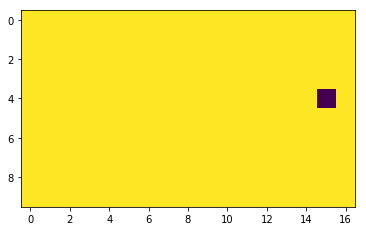

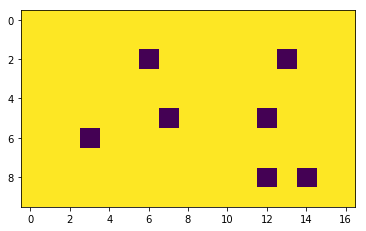

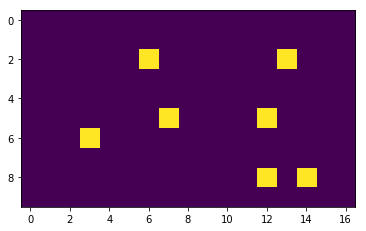

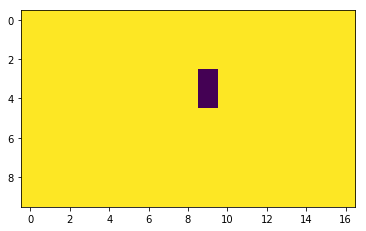

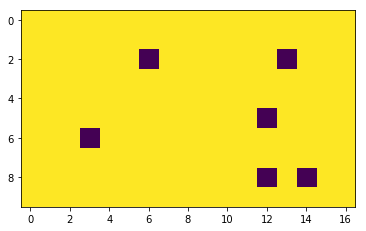

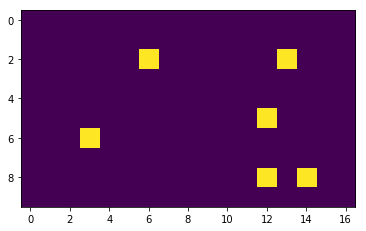

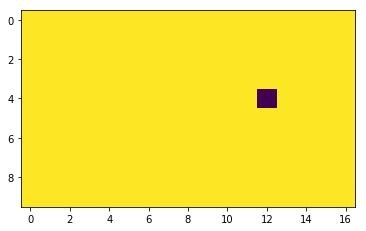

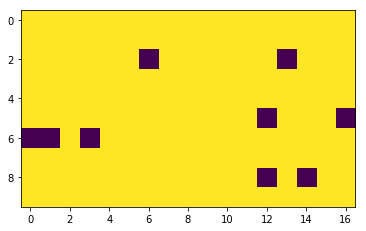

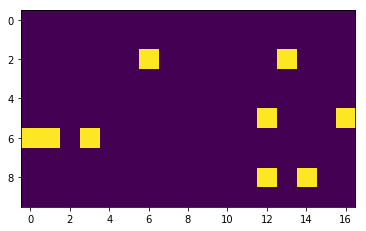

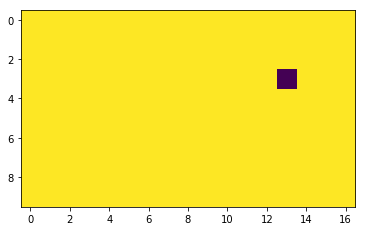

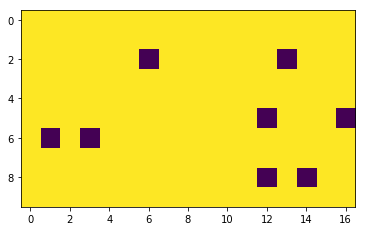

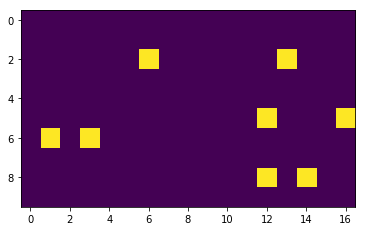

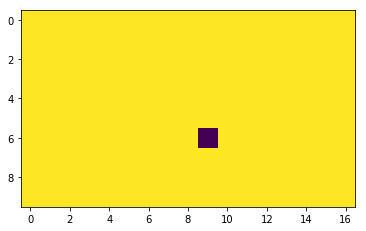

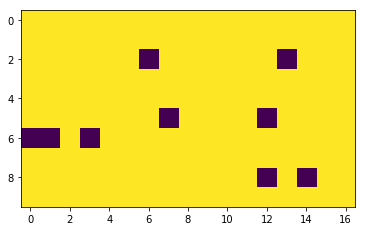

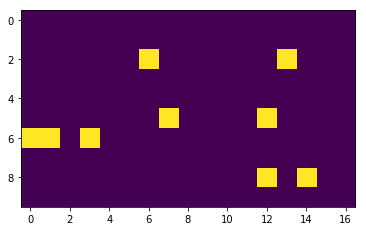

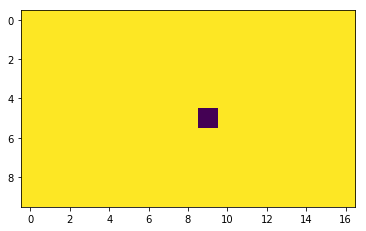

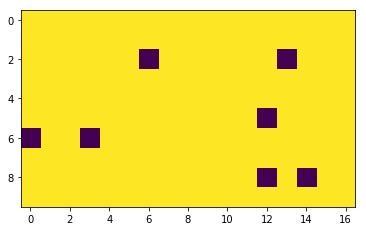

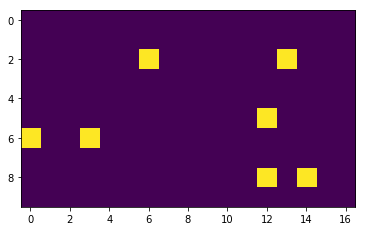

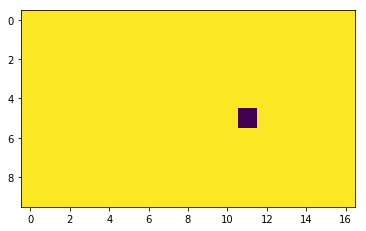

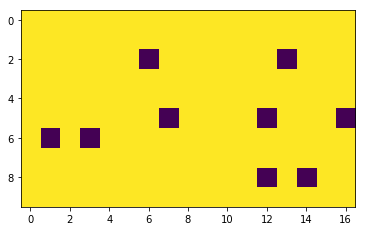

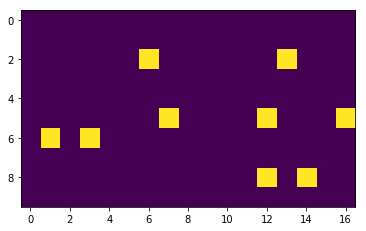

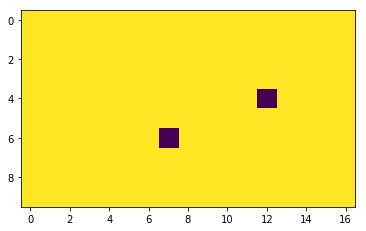

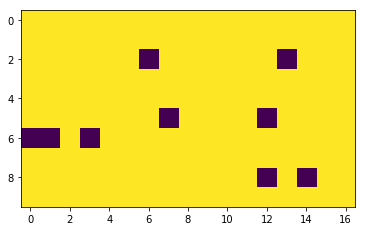

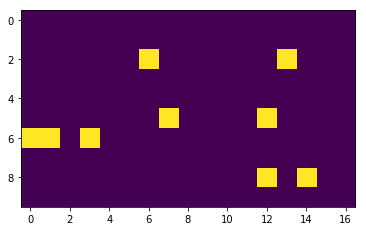

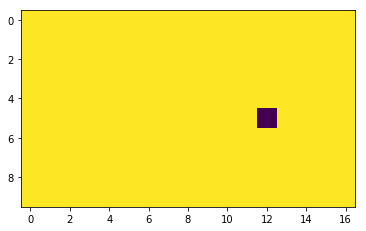

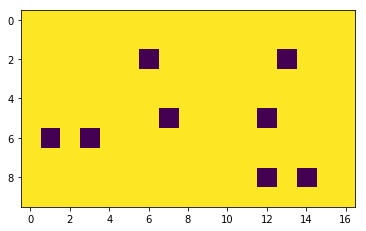

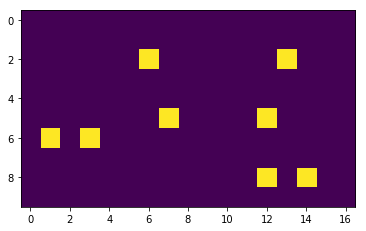

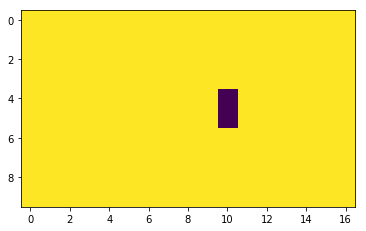

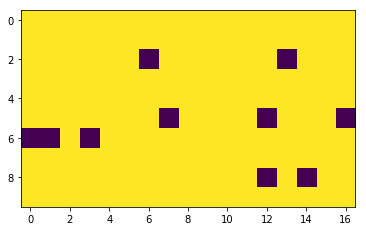

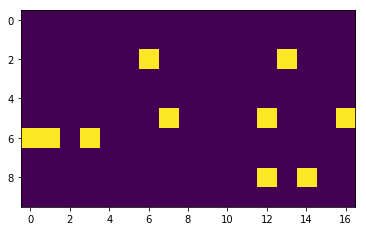

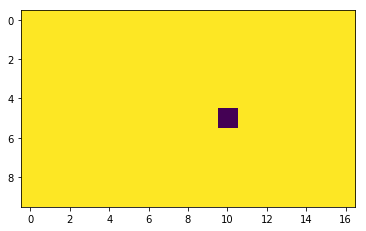

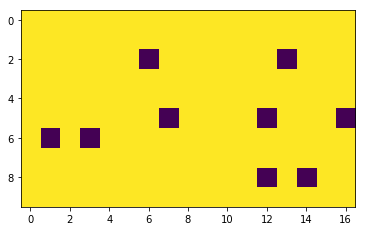

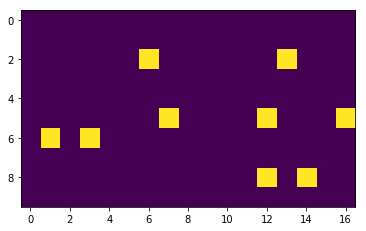

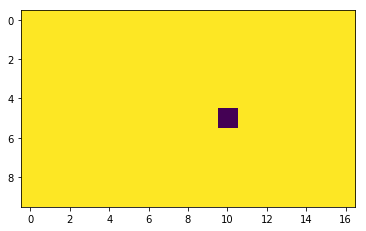

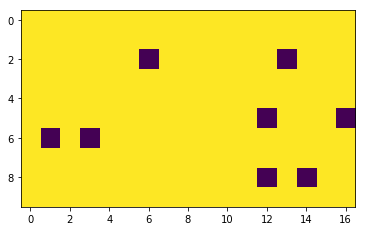

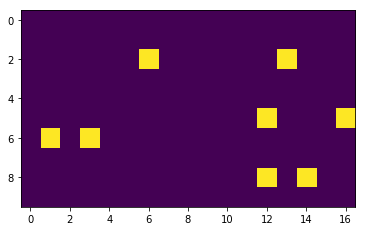

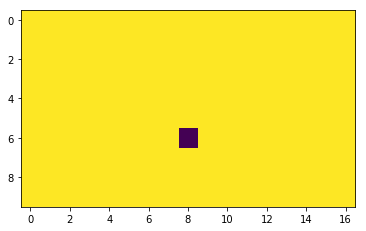

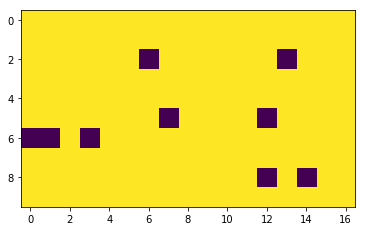

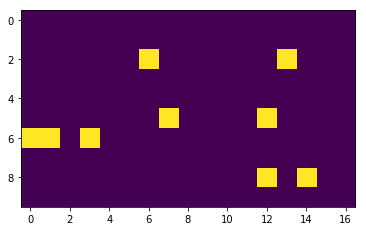

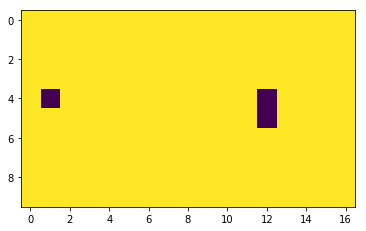

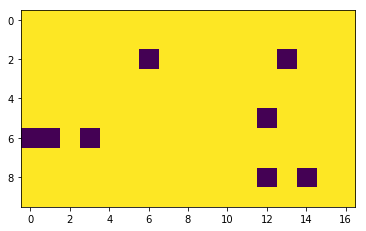

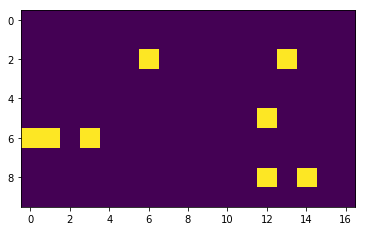

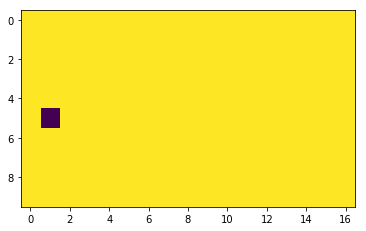

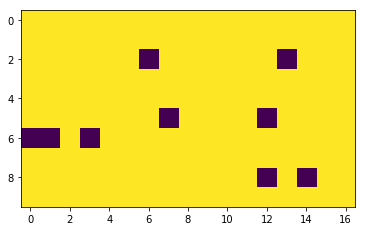

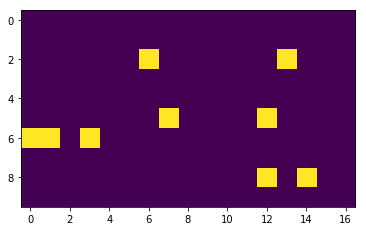

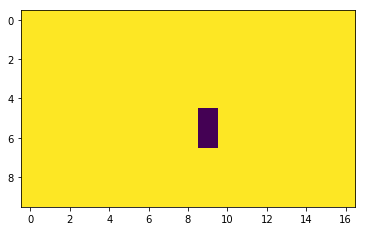

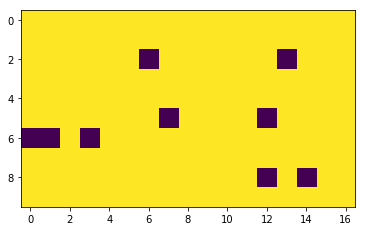

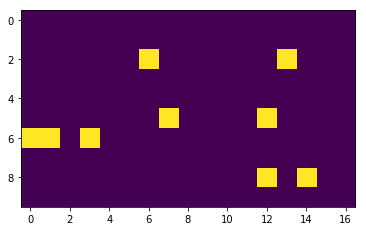

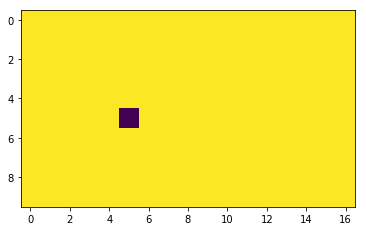

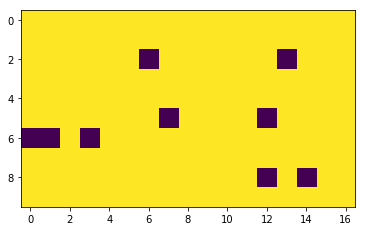

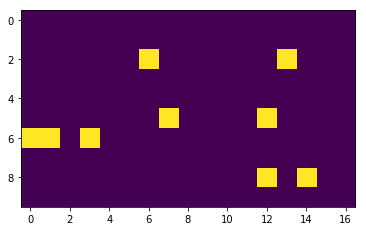

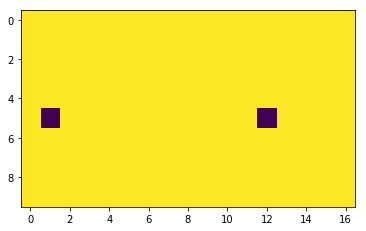

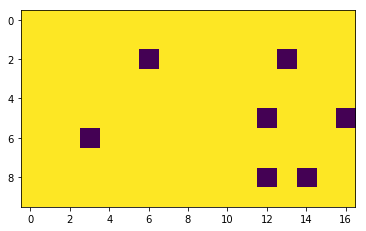

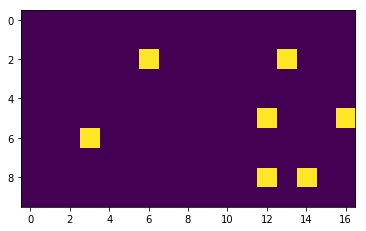

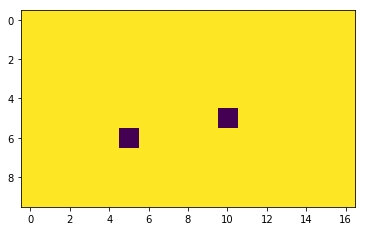

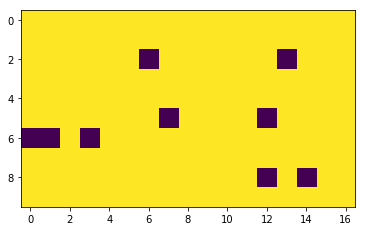

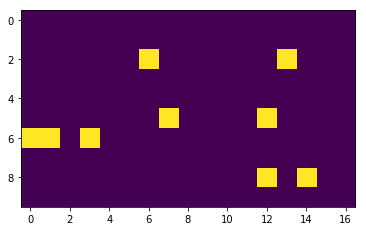

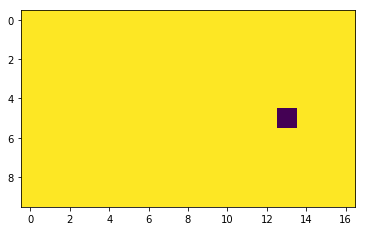

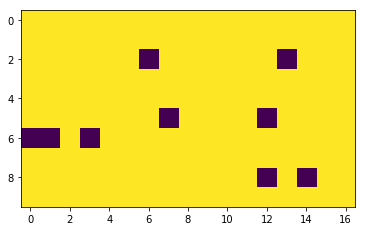

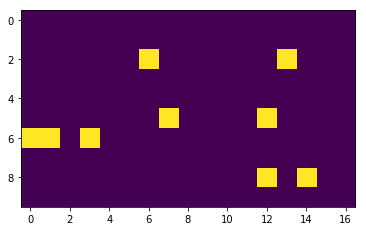

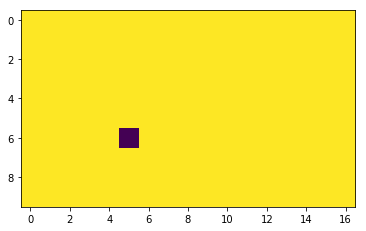

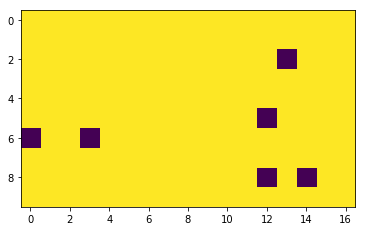

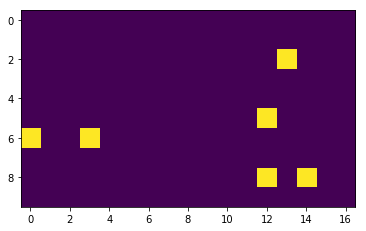

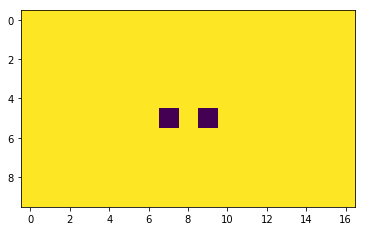

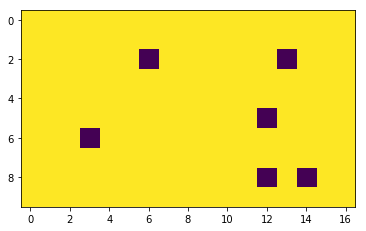

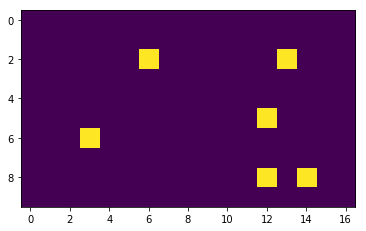

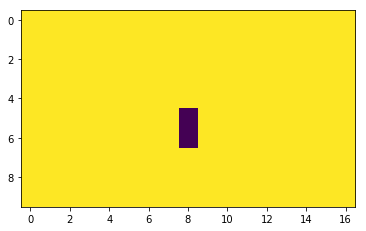

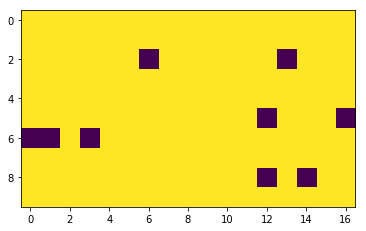

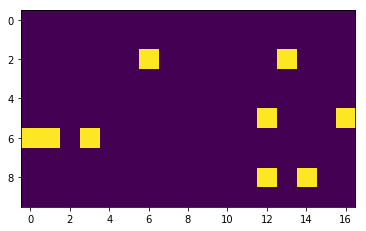

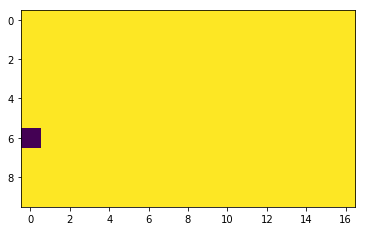

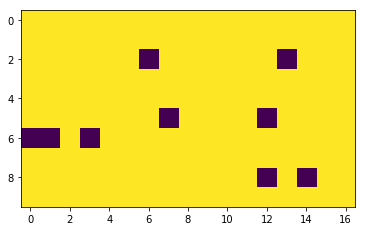

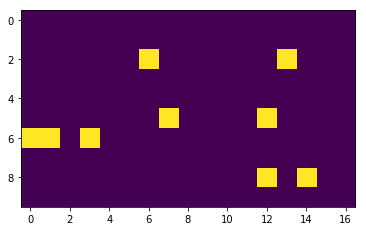

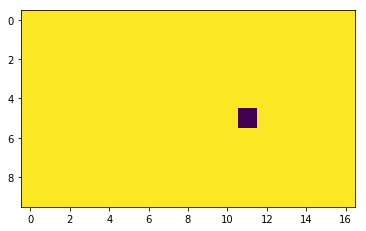

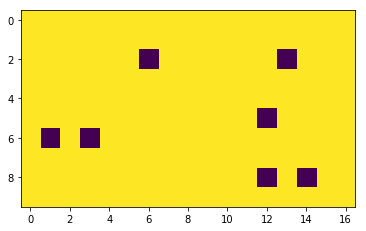

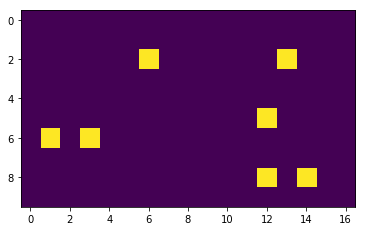

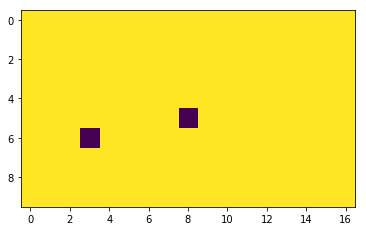

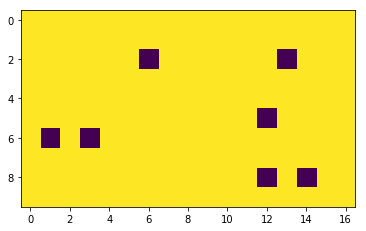

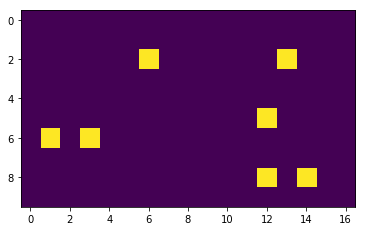

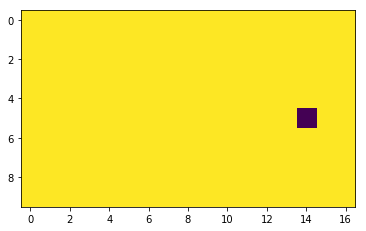

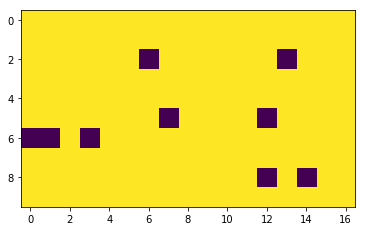

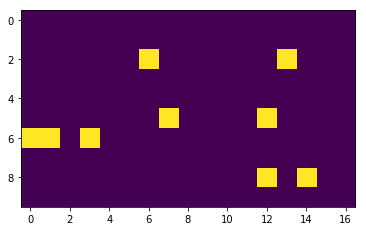

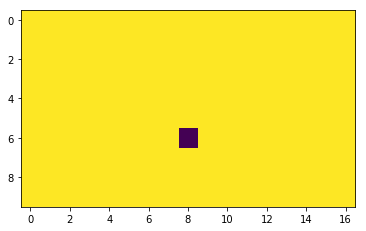

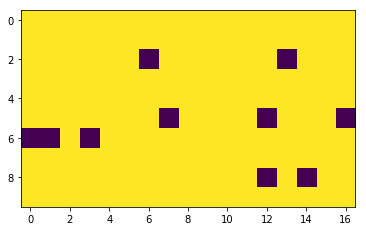

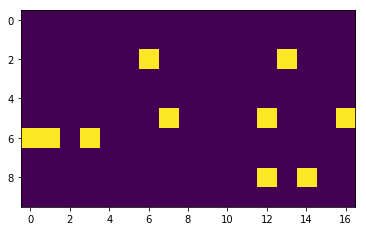

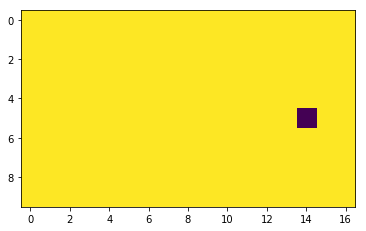

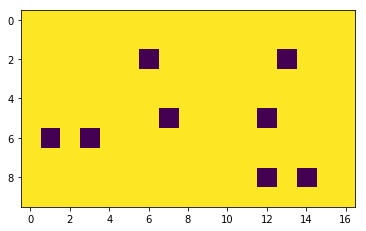

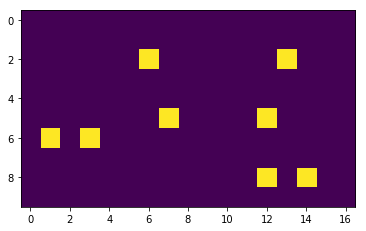

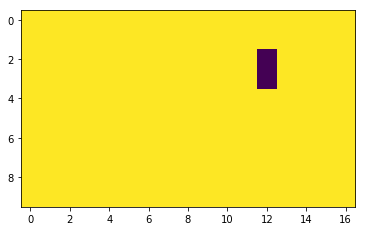

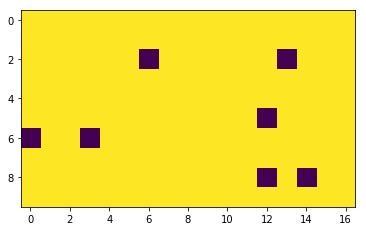

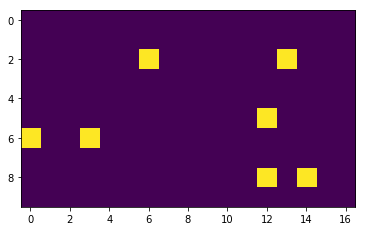

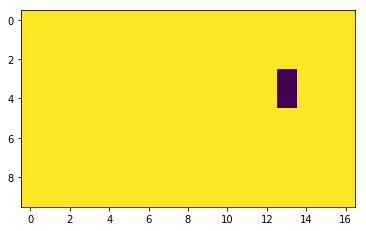

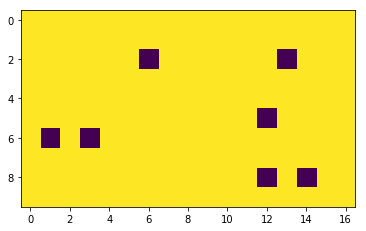

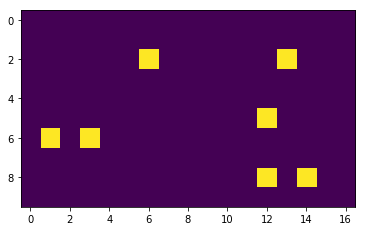

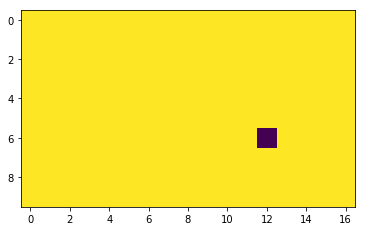

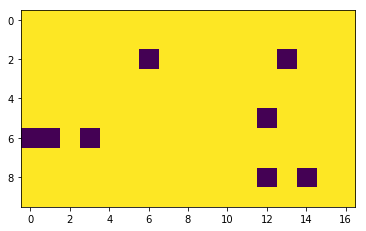

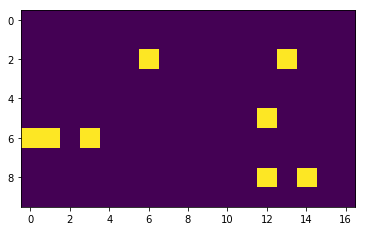

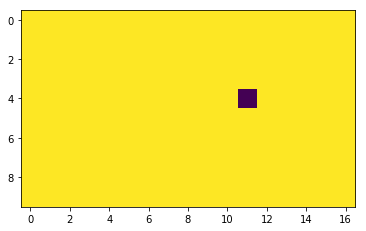

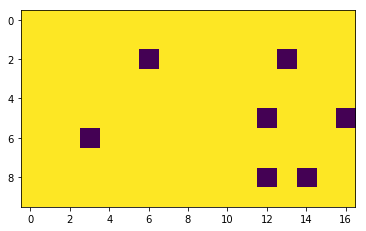

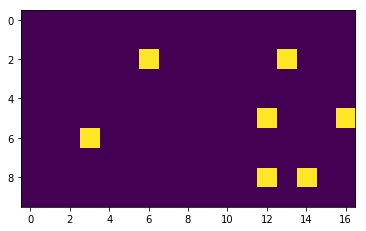

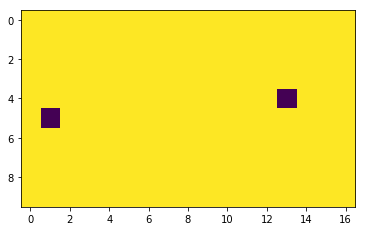

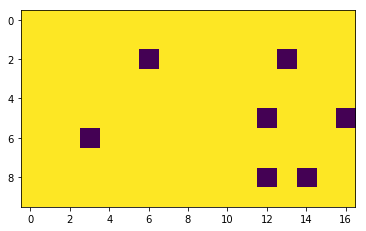

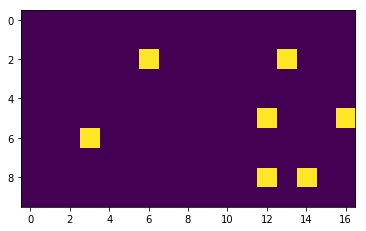

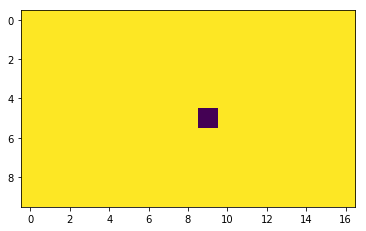

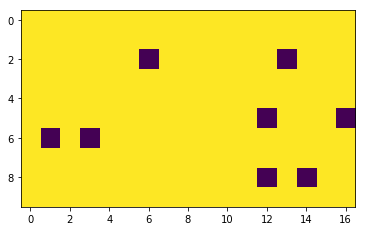

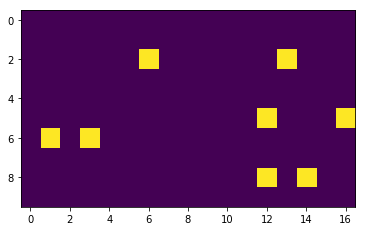

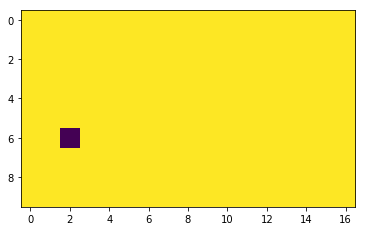

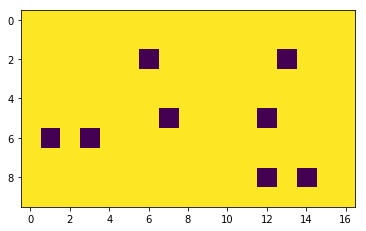

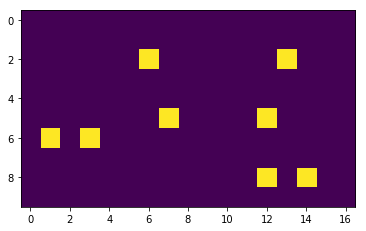

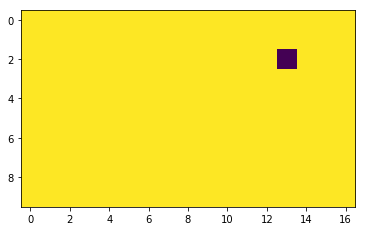

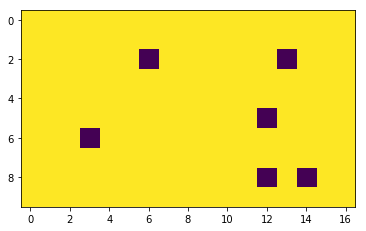

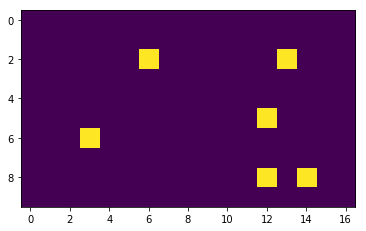

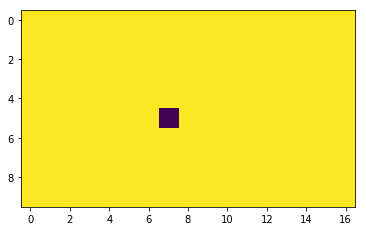

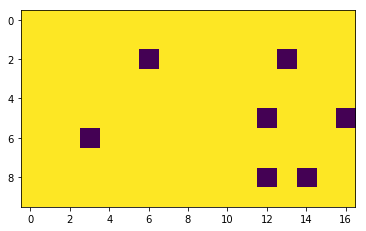

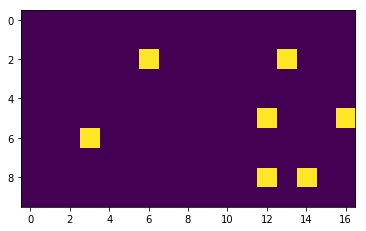

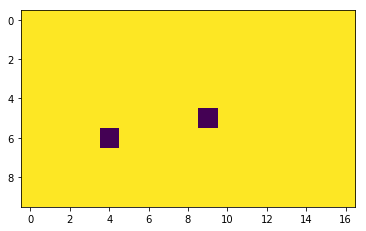

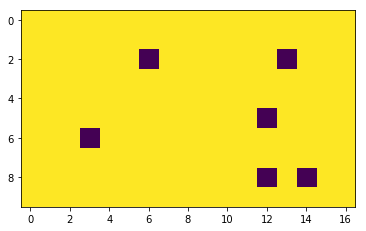

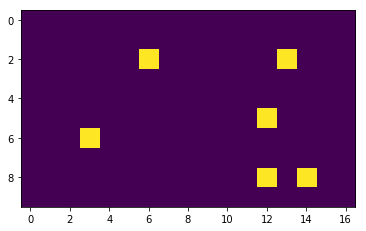

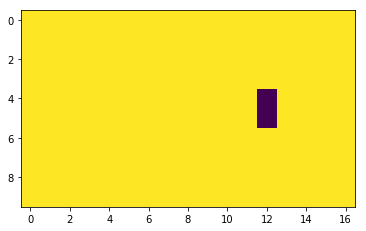

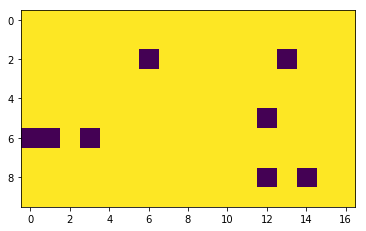

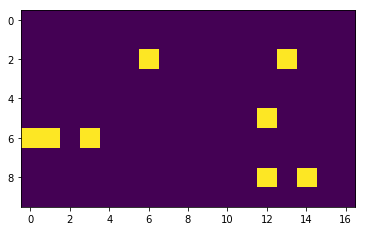

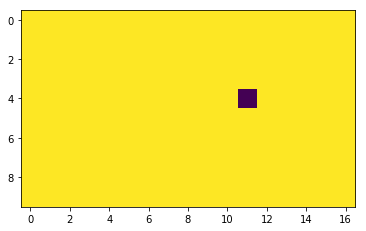

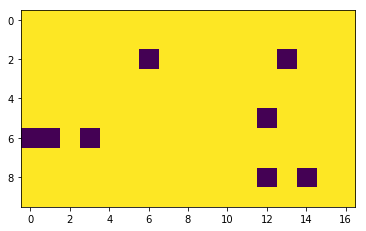

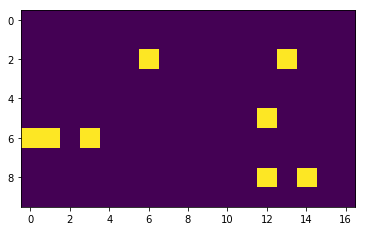

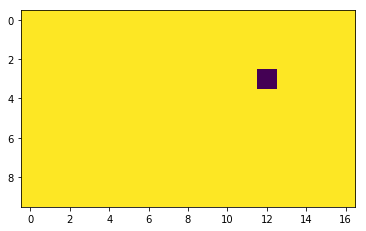

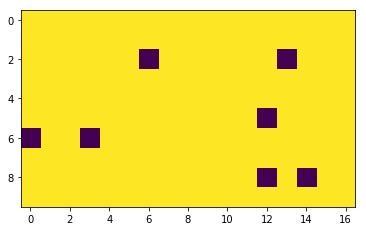

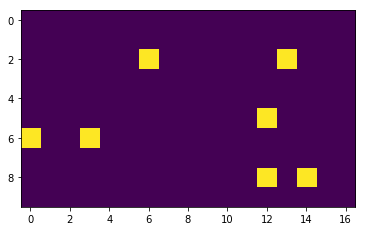

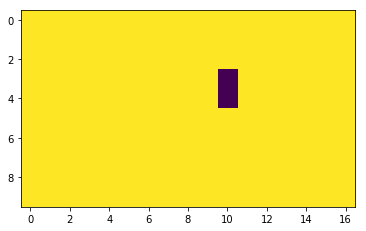

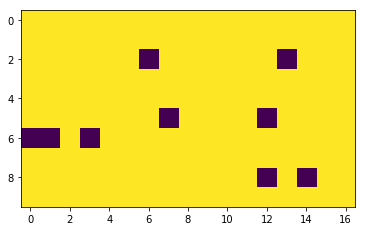

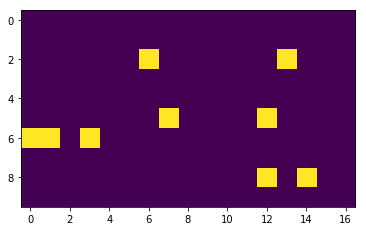

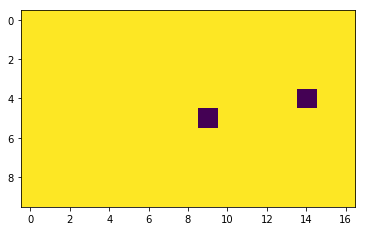

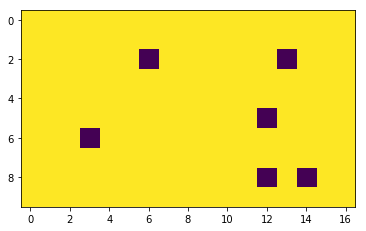

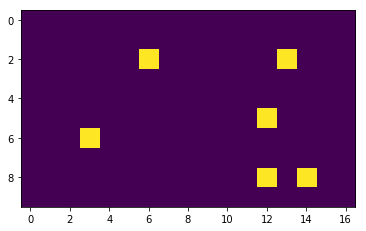

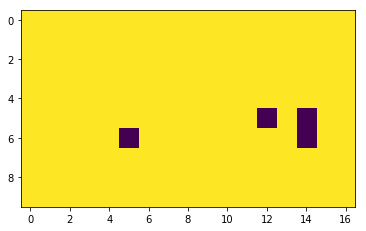

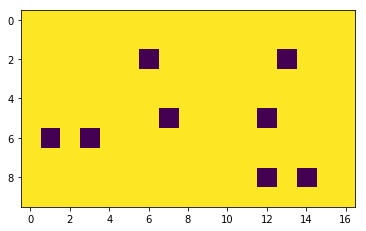

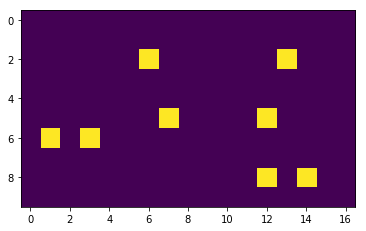

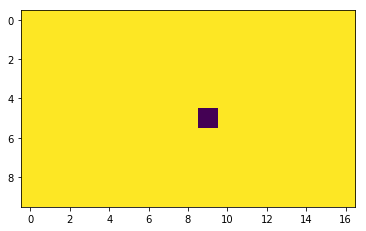

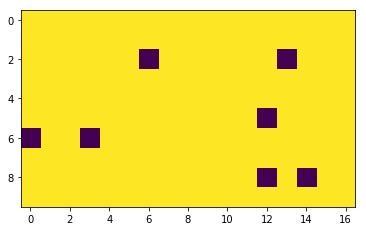

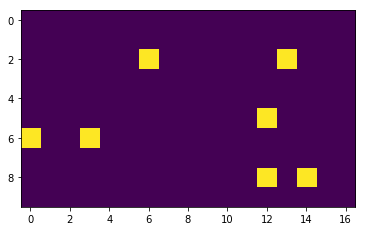

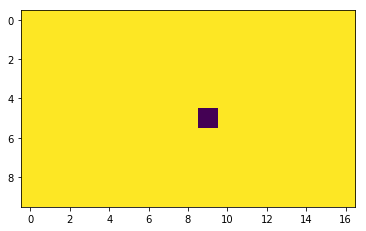

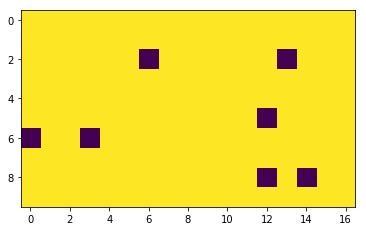

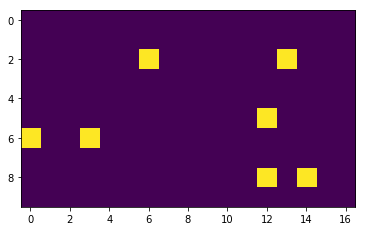

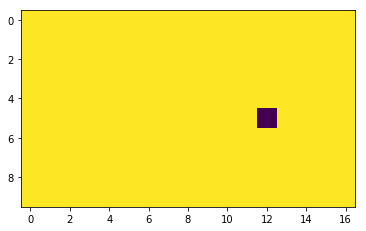

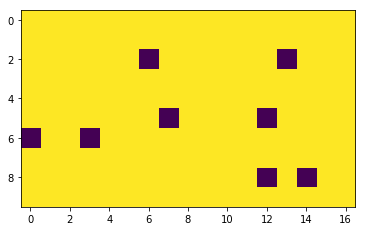

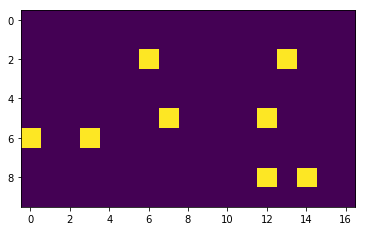

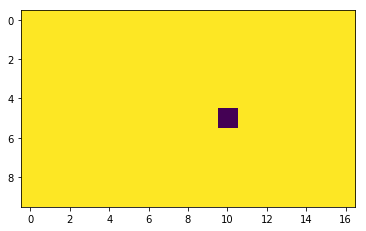

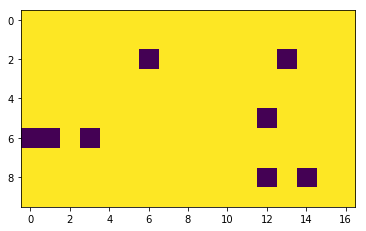

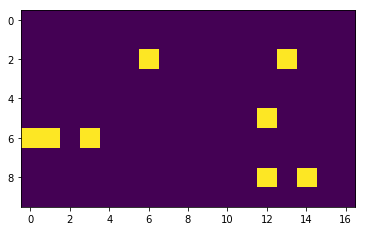

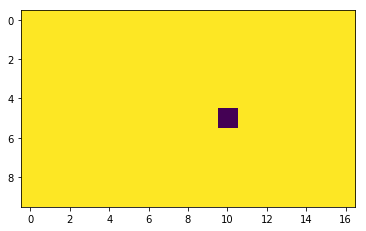

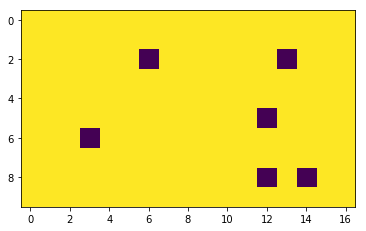

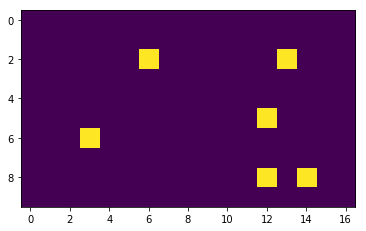

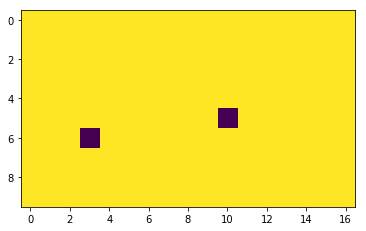

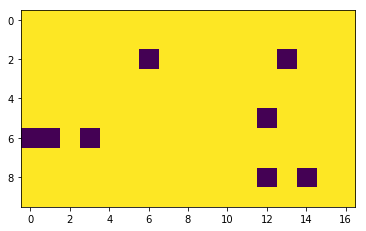

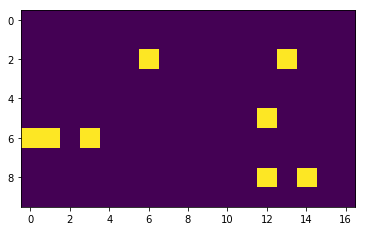

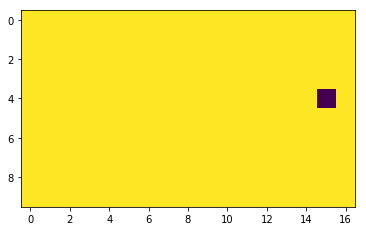

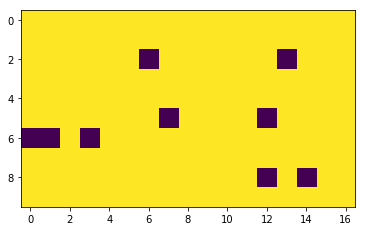

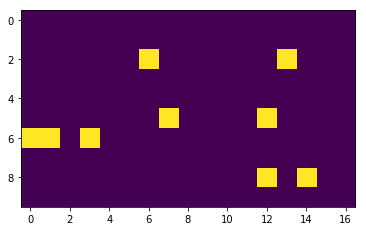

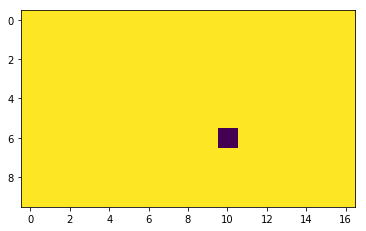

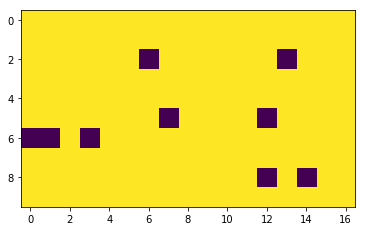

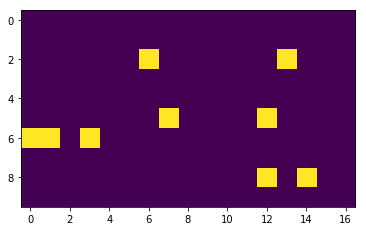

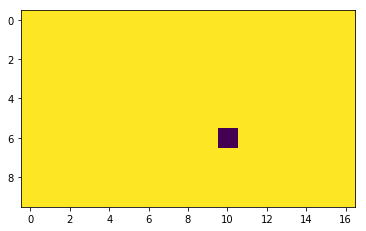

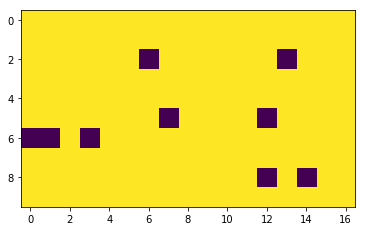

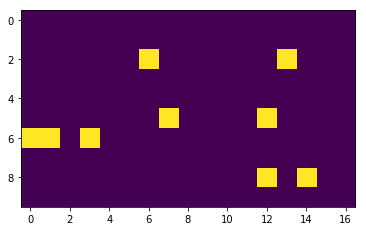

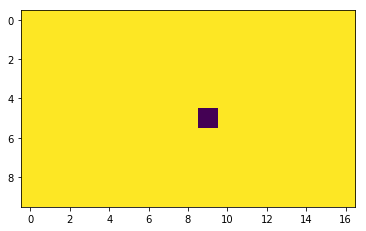

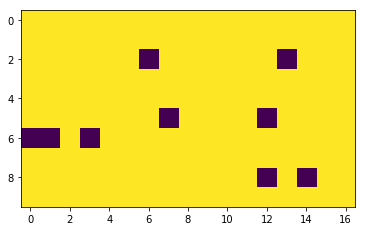

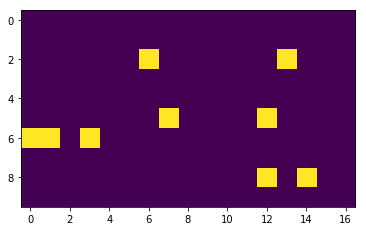

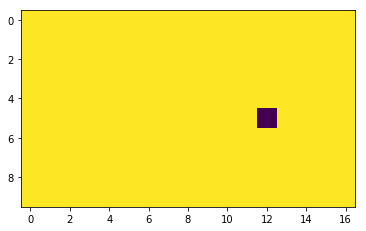

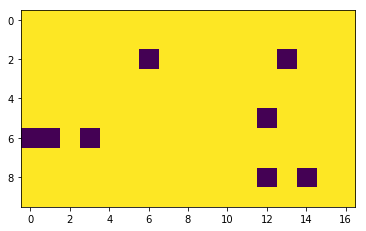

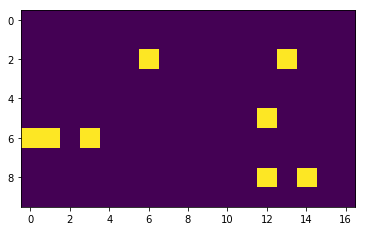

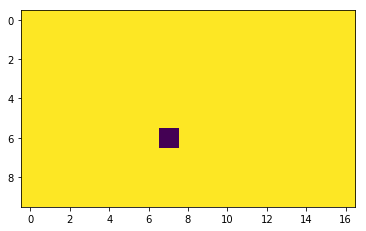

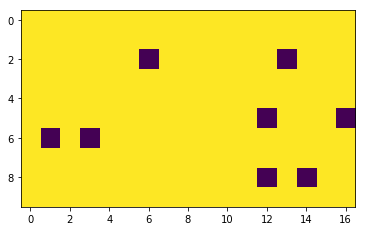

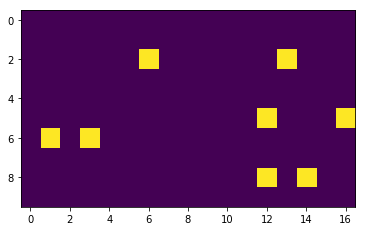

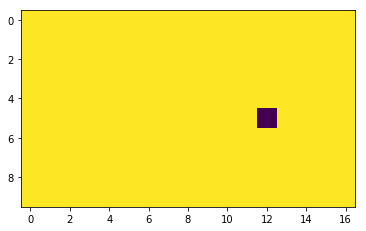

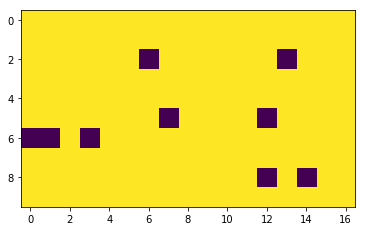

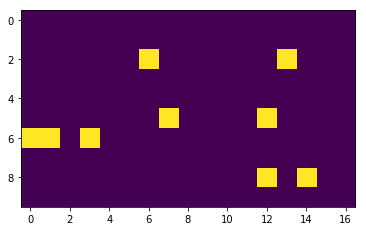

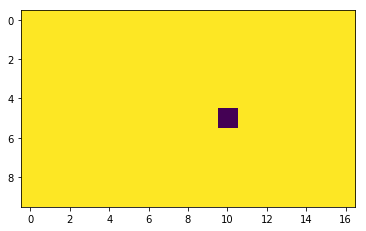

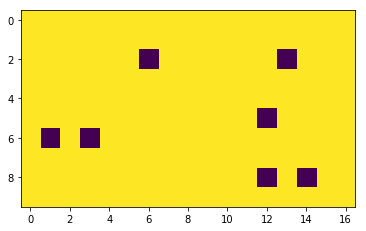

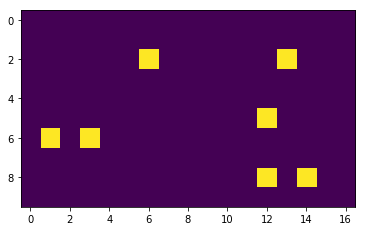

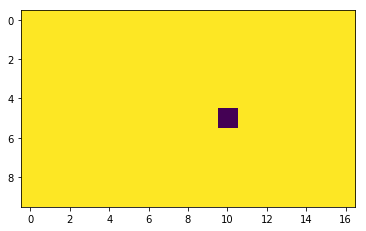

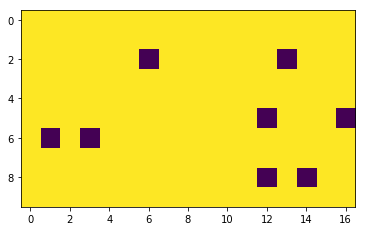

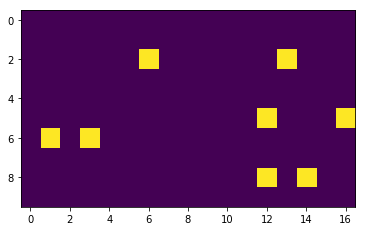

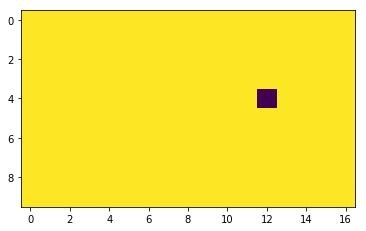

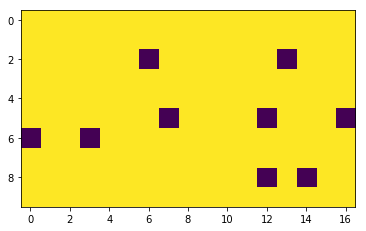

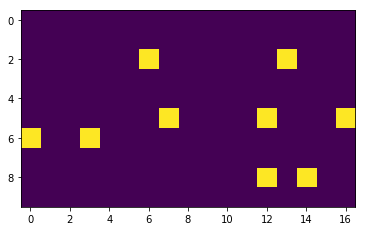

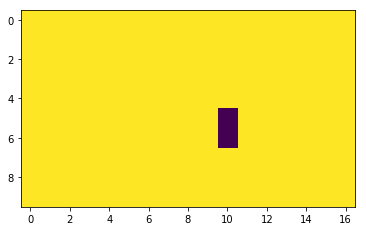

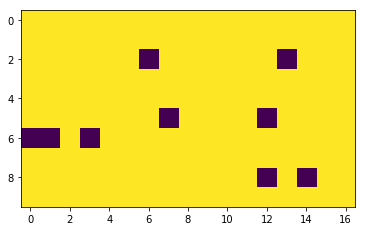

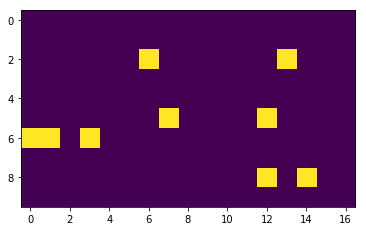

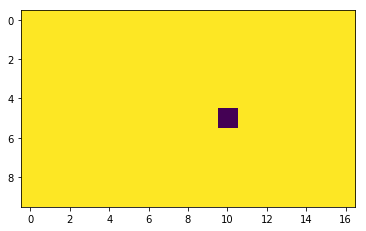

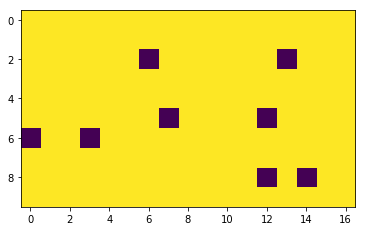

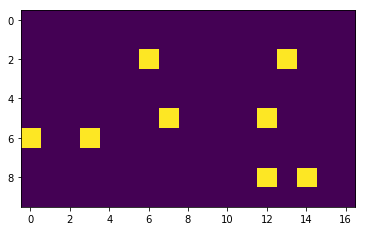

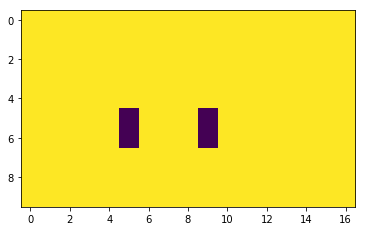

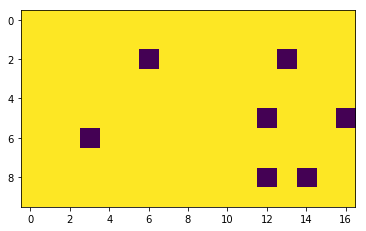

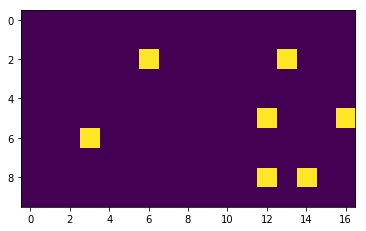

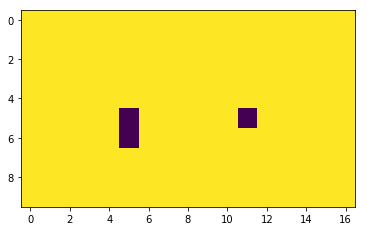

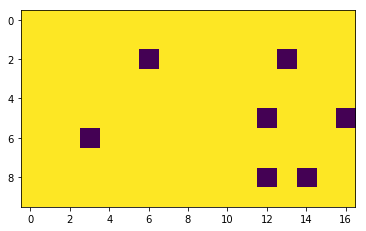

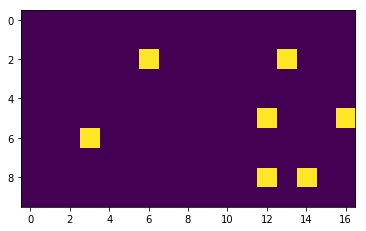

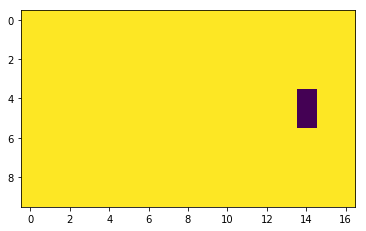

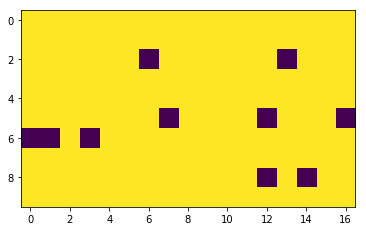

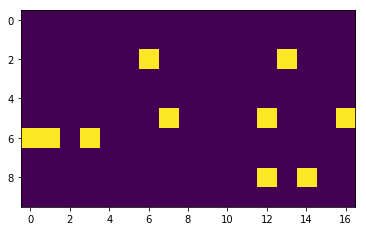

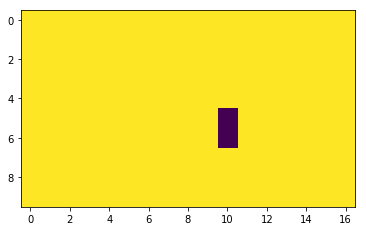

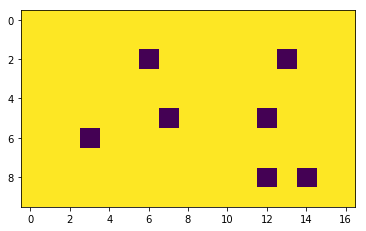

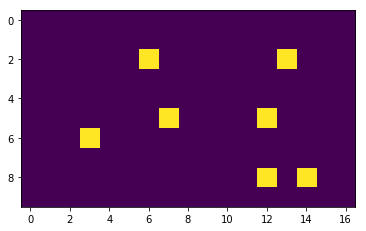

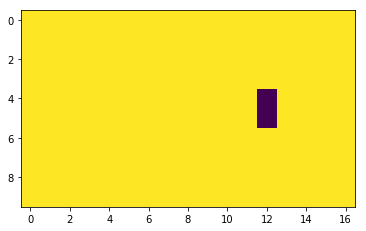

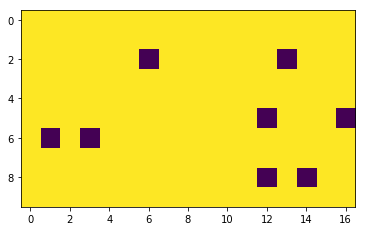

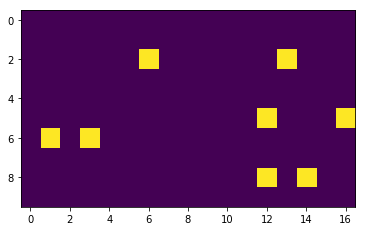

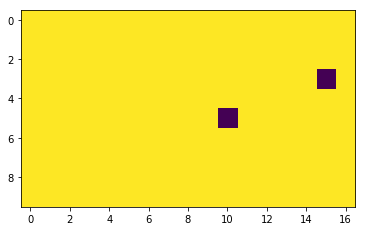

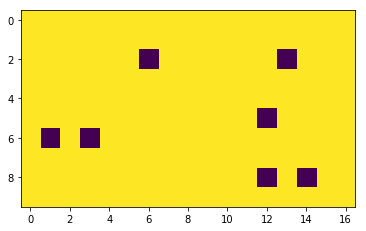

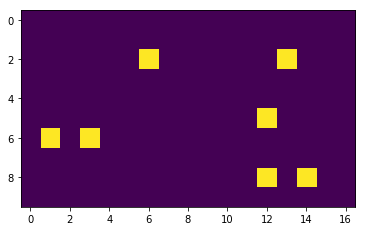

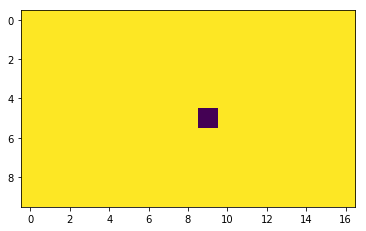

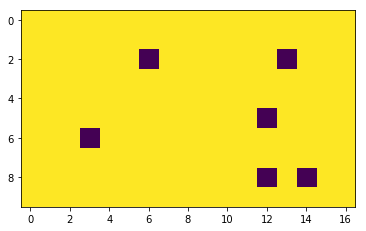

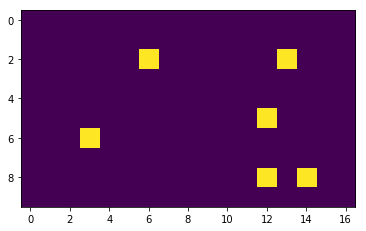

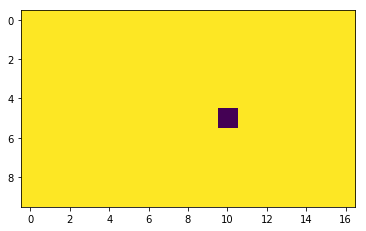

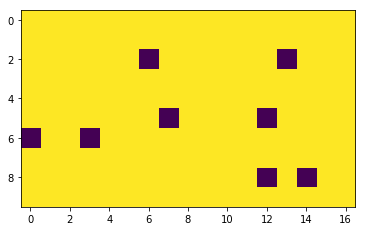

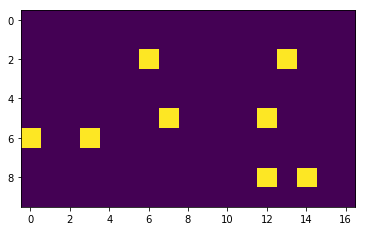

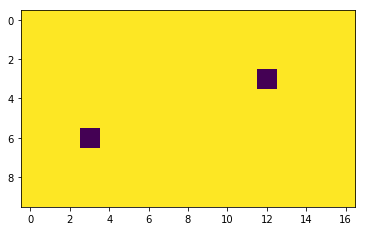

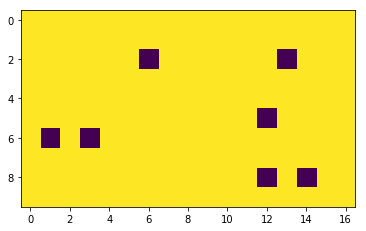

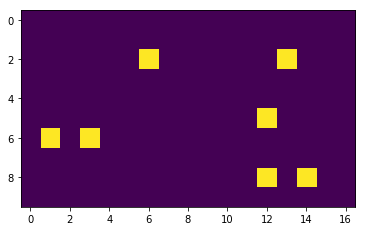

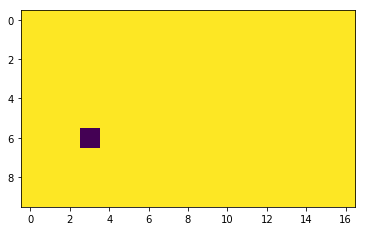

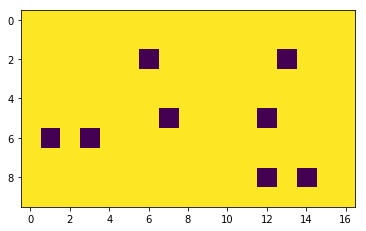

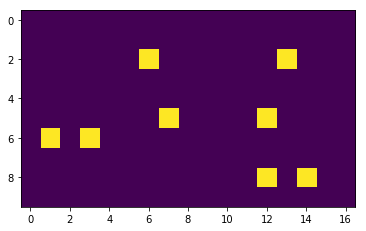

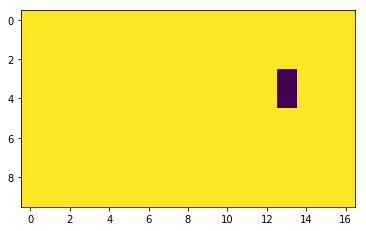

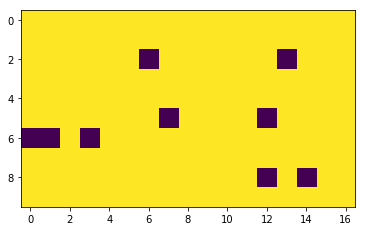

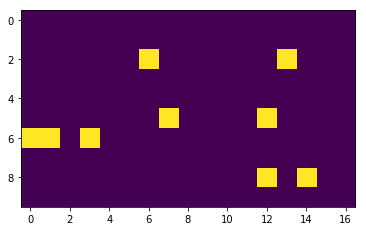

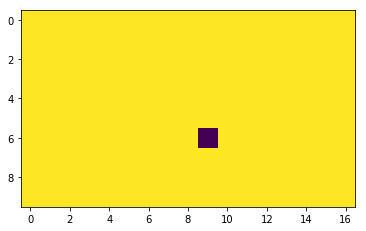

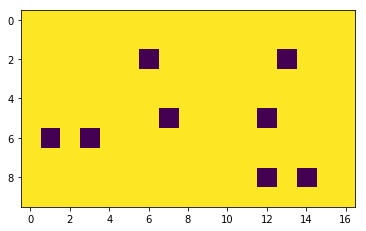

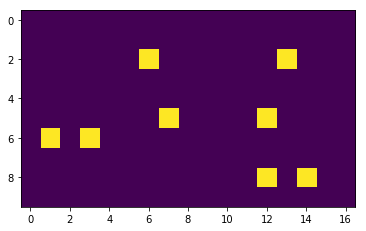

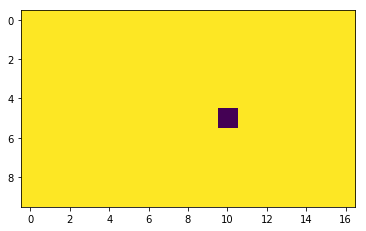

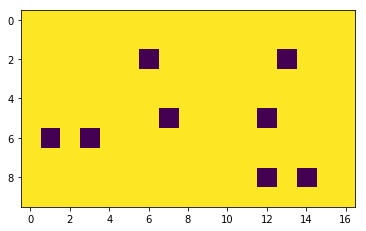

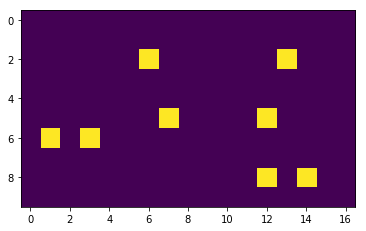

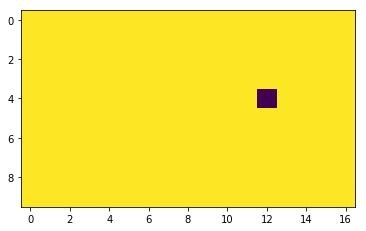

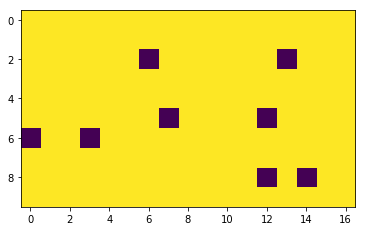

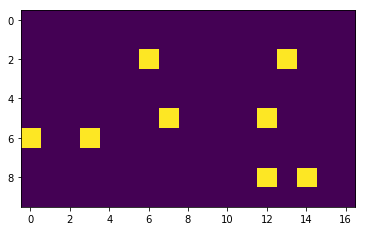

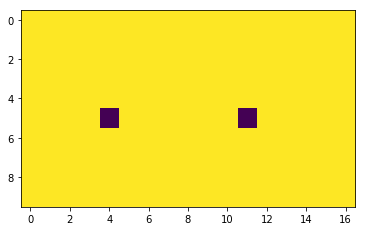

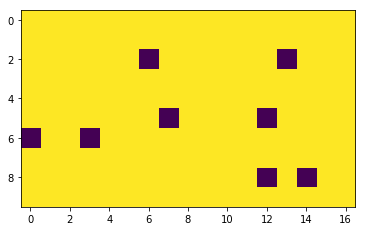

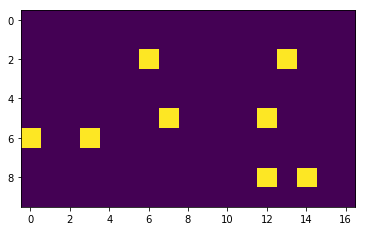

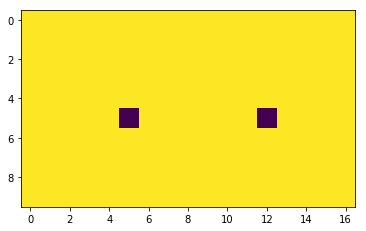

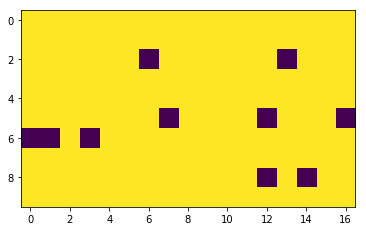

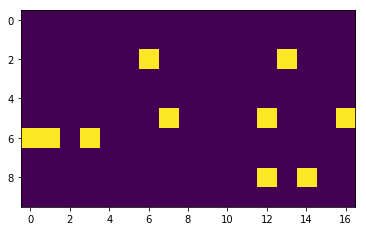

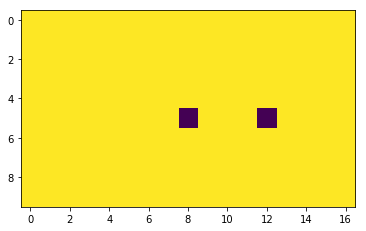

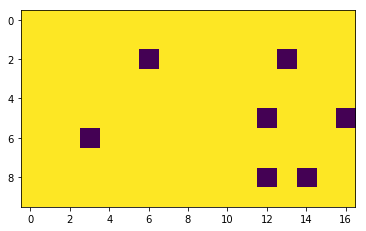

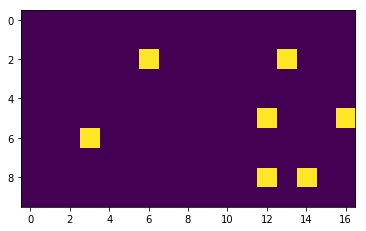

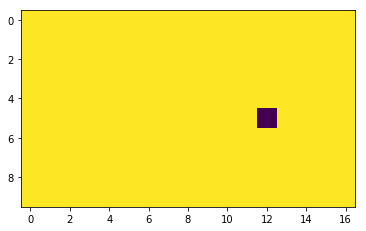

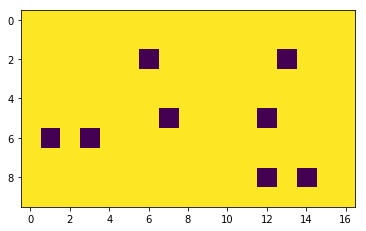

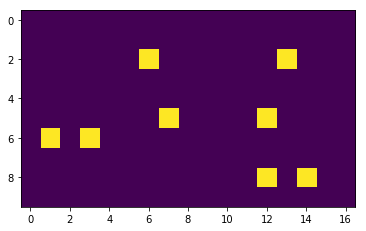

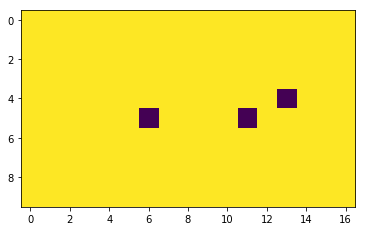

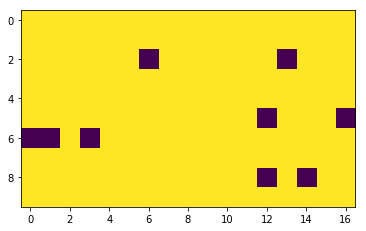

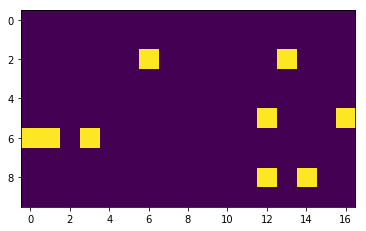

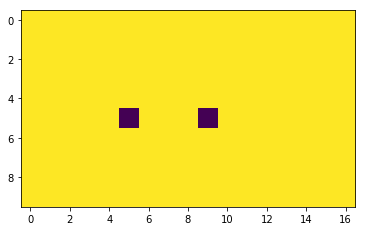

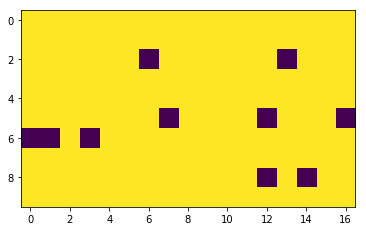

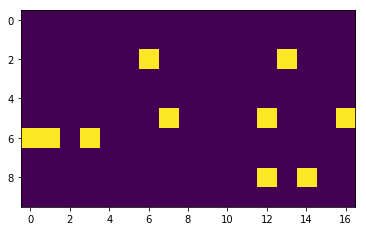

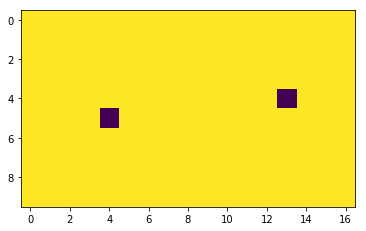

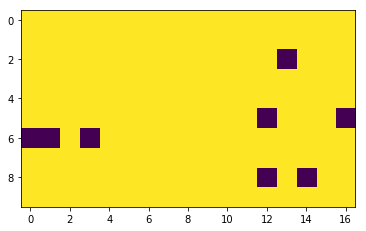

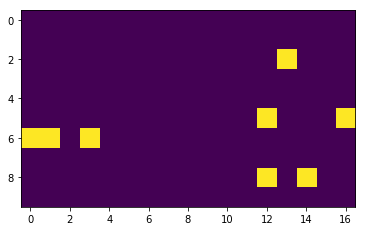

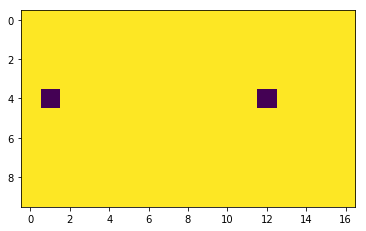

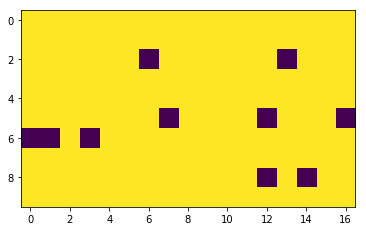

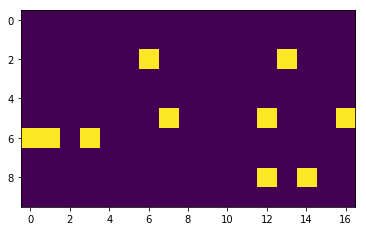

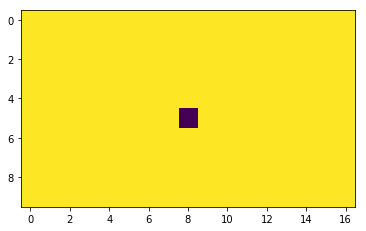

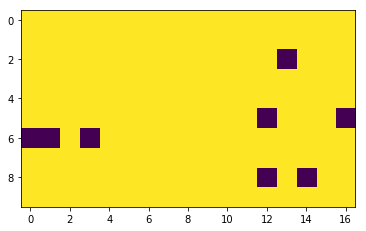

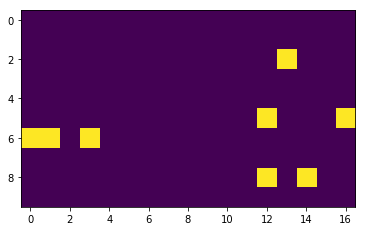

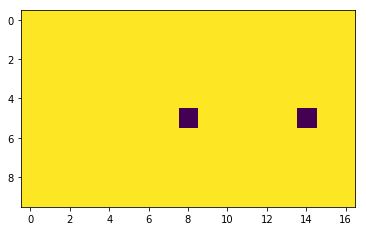

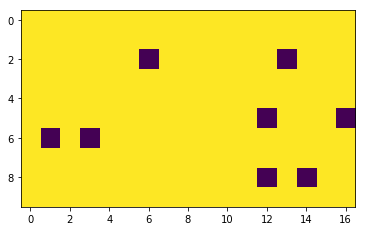

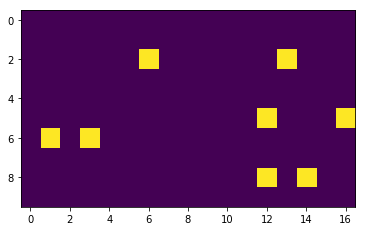

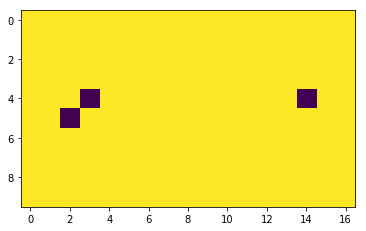

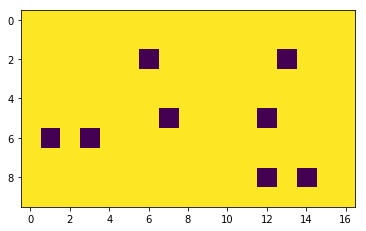

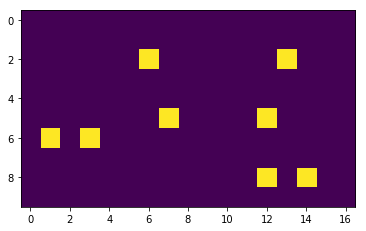

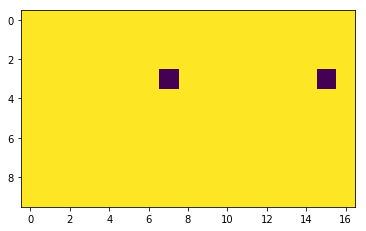

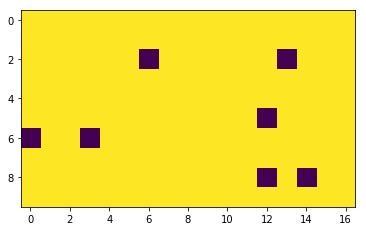

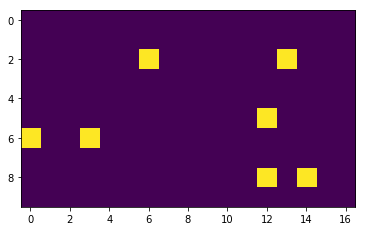

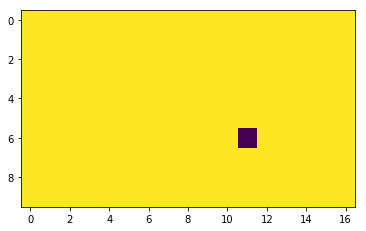

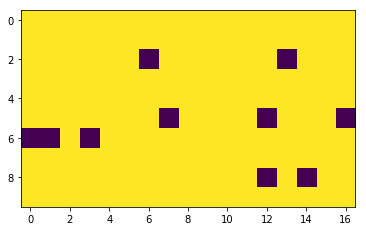

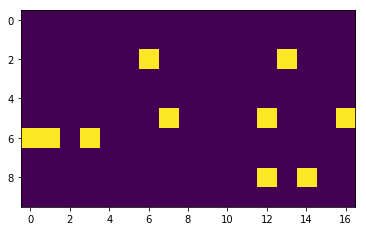

In [21]:
for i in range(n_img):
    plt.imshow(labels_nn[i,:,:,0].reshape((10, 17)))
    plt.show()
    plt.imshow(res[i,:,:,0].reshape((10, 17)))
    plt.show()
    plt.imshow(res[i,:,:,1].reshape((10, 17)))
    plt.show()

In [19]:
model_final.fit(images[:n_img, :, :, :], labels_nn[:n_img, :, :, :], min(batch_size, n_img), 1000)

Epoch 1/1000
100/100 [==============================] - 22s - loss: 0.0592 - acc: 0.9407    
Epoch 2/1000
100/100 [==============================] - 21s - loss: 0.0538 - acc: 0.9462    
Epoch 3/1000
100/100 [==============================] - 21s - loss: 0.0538 - acc: 0.9462    
Epoch 4/1000
100/100 [==============================] - 21s - loss: 0.0538 - acc: 0.9462    
Epoch 5/1000
100/100 [==============================] - 21s - loss: 0.0538 - acc: 0.9462    
Epoch 6/1000
100/100 [==============================] - 21s - loss: 0.0538 - acc: 0.9462    
Epoch 7/1000
100/100 [==============================] - 21s - loss: 0.0538 - acc: 0.9462    
Epoch 8/1000
100/100 [==============================] - 21s - loss: 0.0538 - acc: 0.9462    
Epoch 9/1000
 85/100 [========================>.....] - ETA: 3s - loss: 0.0538 - acc: 0.9462

KeyboardInterrupt: 

In [ ]:
res[0,:,:,0]